# Finish Here
# 3rd Notebook

In [266]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread 
import seaborn as sns
import statsmodels.api as sm
from PIL import Image
import os

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Neural network libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.layers import Dense, Dropout, Flatten, LayerNormalization
from tensorflow.keras.utils import to_categorical

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices, dmatrix, demo_data

%matplotlib inline
np.random.seed(42)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

### Reading in Data

In [2]:
df= pd.read_csv('/Users/meiralelov/Documents/Flatiron/Projects/natural_product_classifier/notebooks/datasetnew.tsv', sep='\t')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df

,ChEBI,MolecularFormula,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,...,Rn,Fr,Ra,Ac,Th,Pa,U,FCharge,RoleType,RoleName
0,19032,C2H4BrCl,143.410,1.6,NaN,NaN,0.0,10.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,mutagen
1,21182,C23H30Cl5N3O,541.800,NaN,NaN,NaN,37.4,494.0,NaN,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,intercalator
2,21183,C21H27Cl4N3O,479.300,NaN,NaN,NaN,37.4,442.0,NaN,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,intercalator
3,28925,C5H11Cl2N,156.050,0.9,NaN,NaN,3.2,43.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,alkylating agent
4,40910,N3-,42.021,1.5,NaN,NaN,3.0,15.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,biological role,mitochondrial respiratory-chain inhibitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,131528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10484,90785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10485,77774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,phosphodiesterase IV inhibitor
10486,83335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,application,antifungal agrochemical


In [3]:
df.MolecularFormula.duplicated().sum()

3818

In [4]:
df.drop(['MolecularFormula'], axis=1, inplace=True)

### Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10488 entries, 0 to 10487
Columns: 114 entries, ChEBI to RoleName
dtypes: float64(111), int64(1), object(2)
memory usage: 9.1+ MB


In [6]:
df.dtypes

ChEBI                 int64
MolecularWeight     float64
XLogP               float64
ExactMass           float64
MonoisotopicMass    float64
                     ...   
Pa                  float64
U                   float64
FCharge             float64
RoleType             object
RoleName             object
Length: 114, dtype: object

In [7]:
df.describe()

,ChEBI,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,FCharge
count,10488.000000,10136.000000,9460.000000,0.0,0.0,10136.000000,10136.000000,0.0,10136.000000,10136.000000,...,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.000000
mean,74864.215103,416.048117,2.137970,NaN,NaN,124.505397,611.892463,NaN,3.508287,7.122534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.051500
std,50620.763215,298.143413,5.906588,NaN,NaN,123.788034,581.067692,NaN,4.424729,7.113387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522708
min,25.000000,2.016000,-24.300000,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.000000
25%,51472.250000,222.370000,-0.800000,NaN,NaN,55.800000,246.000000,NaN,1.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,70862.000000,343.370000,2.000000,NaN,NaN,92.400000,468.000000,NaN,2.000000,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,86392.250000,501.600000,4.500000,NaN,NaN,150.000000,797.000000,NaN,4.000000,8.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,744019.000000,4541.000000,40.400000,NaN,NaN,2040.000000,11900.000000,NaN,71.000000,111.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000


In [8]:
df.isnull().sum()

ChEBI                   0
MolecularWeight       352
XLogP                1028
ExactMass           10488
MonoisotopicMass    10488
                    ...  
Pa                    352
U                     352
FCharge               352
RoleType                0
RoleName                0
Length: 114, dtype: int64

In [9]:
df.index.duplicated().sum()

0

In [10]:
df.duplicated().sum()

0

In [11]:
df.shape

(10488, 114)

### Data Cleaning

In [12]:
cols = list(df.columns)

def null_percentage(df, cols):
    
    list_of_percentages = []
    
    for i in cols:
        
        percent = ((df[i].isna().sum())/(len(df))) * 100
    
        list_of_percentages.append(percent)
        
    zip_list = zip(cols, list_of_percentages)   

    return zip_list

# I would like to visualize the percentage specifically associated with each column

In [13]:
list(null_percentage(df, cols))

[('ChEBI', 0.0),
 ('MolecularWeight', 3.3562166285278416),
 ('XLogP', 9.801678108314265),
 ('ExactMass', 100.0),
 ('MonoisotopicMass', 100.0),
 ('TPSA', 3.3562166285278416),
 ('Complexity', 3.3562166285278416),
 ('Charge', 100.0),
 ('HBondDonorCount', 3.3562166285278416),
 ('HBondAcceptorCount', 3.3562166285278416),
 ('RotatableBondCount', 3.3562166285278416),
 ('HeavyAtomCount', 3.3562166285278416),
 ('IsotopeAtomCount', 100.0),
 ('AtomStereoCount', 100.0),
 ('DefinedAtomStereoCount', 100.0),
 ('UndefinedAtomStereoCount', 100.0),
 ('BondStereoCount', 100.0),
 ('H', 3.3562166285278416),
 ('He', 3.3562166285278416),
 ('Li', 3.3562166285278416),
 ('Be', 3.3562166285278416),
 ('B', 3.3562166285278416),
 ('C', 3.3562166285278416),
 ('N', 3.3562166285278416),
 ('O', 3.3562166285278416),
 ('F', 3.3562166285278416),
 ('Ne', 3.3562166285278416),
 ('Na', 3.3562166285278416),
 ('Mg', 3.3562166285278416),
 ('Al', 3.3562166285278416),
 ('Si', 3.3562166285278416),
 ('P', 3.3562166285278416),
 ('S',

In [14]:
null_list = list(null_percentage(df, cols))

for x in null_list:
    
    if x[1].astype(float) < 5:

        df.dropna(axis=0,subset=[x[0]], inplace=True)  

In [15]:
null_list = list(null_percentage(df, cols))
null_list

[('ChEBI', 0.0),
 ('MolecularWeight', 0.0),
 ('XLogP', 6.669297553275453),
 ('ExactMass', 100.0),
 ('MonoisotopicMass', 100.0),
 ('TPSA', 0.0),
 ('Complexity', 0.0),
 ('Charge', 100.0),
 ('HBondDonorCount', 0.0),
 ('HBondAcceptorCount', 0.0),
 ('RotatableBondCount', 0.0),
 ('HeavyAtomCount', 0.0),
 ('IsotopeAtomCount', 100.0),
 ('AtomStereoCount', 100.0),
 ('DefinedAtomStereoCount', 100.0),
 ('UndefinedAtomStereoCount', 100.0),
 ('BondStereoCount', 100.0),
 ('H', 0.0),
 ('He', 0.0),
 ('Li', 0.0),
 ('Be', 0.0),
 ('B', 0.0),
 ('C', 0.0),
 ('N', 0.0),
 ('O', 0.0),
 ('F', 0.0),
 ('Ne', 0.0),
 ('Na', 0.0),
 ('Mg', 0.0),
 ('Al', 0.0),
 ('Si', 0.0),
 ('P', 0.0),
 ('S', 0.0),
 ('Cl', 0.0),
 ('A', 0.0),
 ('K', 0.0),
 ('Ca', 0.0),
 ('Sc', 0.0),
 ('Ti', 0.0),
 ('Ti.1', 0.0),
 ('V', 0.0),
 ('Cr', 0.0),
 ('Mn', 0.0),
 ('Fe', 0.0),
 ('Co', 0.0),
 ('Ni', 0.0),
 ('Cu', 0.0),
 ('Zn', 0.0),
 ('Ga', 0.0),
 ('Ge', 0.0),
 ('As', 0.0),
 ('Se', 0.0),
 ('Br', 0.0),
 ('Kr', 0.0),
 ('Rb', 0.0),
 ('Sr', 0.0),
 (

In [16]:
df.shape

(10136, 114)

In [17]:
clean_df = df.drop(['ExactMass', 'MonoisotopicMass', 'Charge', 'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount','UndefinedAtomStereoCount', 'BondStereoCount'], axis=1)

In [18]:
clean_df.XLogP.isnull().value_counts()

False    9460
True      676
Name: XLogP, dtype: int64

In [19]:
clean_df[pd.isnull(clean_df.XLogP)].RoleType.value_counts()

application        358
biological role    266
chemical role       52
Name: RoleType, dtype: int64

In [20]:
clean_df.XLogP.value_counts().sort_values()
#because domain knowledge of XLogP is that values all have a significance, we can't assign 0 as a neutral value.
#instead, we will asign most frequent as neutral value.
#because the number of nulls associataed with XLogP is 676, which is 5 times the amount of the most frequent value,
#we can't simply add it, but rather we need to bin. Otherwise, the most frequent class will be a lot more frequent. 
#1.5 is most frequent, and the top 5 most frequent values are close enough to one another. 
#I can add values to the most frequent class without the data being affected more. 

-24.3      1
 22.3      1
 24.8      1
 23.0      1
 26.4      1
        ... 
 2.4     115
 2.1     115
 2.5     119
 2.0     121
 1.5     129
Name: XLogP, Length: 418, dtype: int64

In [21]:
ser, bins= pd.qcut(clean_df.XLogP, retbins=True, q=5)

In [22]:
ser.value_counts()

(-24.301000000000002, -1.8]    1926
(-1.8, 1.0]                    1906
(5.2, 40.4]                    1890
(2.8, 5.2]                     1887
(1.0, 2.8]                     1851
Name: XLogP, dtype: int64

In [23]:
bins

array([-24.3,  -1.8,   1. ,   2.8,   5.2,  40.4])

In [24]:
clean_df['XLogP_qcut'] = pd.cut(clean_df.XLogP, bins=bins, labels=False)
clean_df.drop('XLogP', axis=1, inplace=True)
clean_df.XLogP_qcut.value_counts()

0.0    1925
1.0    1906
4.0    1890
3.0    1887
2.0    1851
Name: XLogP_qcut, dtype: int64

In [25]:
cols = list(clean_df.columns.values) #Make a list of all of the columns in the df

cols.pop(cols.index('RoleType')) #Remove b from list
cols.pop(cols.index('RoleName')) #Remove x from list

clean_df = clean_df[cols+['RoleType','RoleName']] #Create new dataframe with columns in the order you want

In [26]:
clean_df.XLogP_qcut.fillna(value=2, inplace=True)
clean_df.XLogP_qcut.value_counts()
#this way, there is not as much of class imbalance

2.0    2528
0.0    1925
1.0    1906
4.0    1890
3.0    1887
Name: XLogP_qcut, dtype: int64

In [27]:
clean_df.shape

(10136, 106)

# Role Type Classification

## Role Type Data

In [28]:
clean_df.RoleType.value_counts()

biological role    8641
application        1329
chemical role       166
Name: RoleType, dtype: int64

In [29]:
bio_rt_df = clean_df[clean_df['RoleType'] == 'biological role']
chem_rt_df = clean_df[clean_df['RoleType'] == 'chemical role']
app_rt_df = clean_df[clean_df['RoleType'] == 'application']

#upsample the minority class and downsample majority
chem_rt_df = resample(chem_rt_df, random_state=42, n_samples=1500, replace=True)
bio_rt_df = resample(bio_rt_df, random_state=42, n_samples=2500, replace=False)

balanced_rt_df = pd.concat([bio_rt_df, chem_rt_df, app_rt_df])
balanced_rt_df.RoleType.value_counts()

biological role    2500
chemical role      1500
application        1329
Name: RoleType, dtype: int64

In [30]:
balanced_rt_df.shape

(5329, 106)

In [31]:
balanced_rt_df

,ChEBI,MolecularWeight,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,H,He,...,Fr,Ra,Ac,Th,Pa,U,FCharge,XLogP_qcut,RoleType,RoleName
9870,143237,232.21,109.0,330.0,2.0,6.0,3.0,15.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,biological role,mouse metabolite
5696,77996,563.90,69.6,574.0,3.0,3.0,31.0,40.0,69.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,biological role,mouse metabolite
814,545687,228.28,74.6,233.0,2.0,4.0,10.0,16.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,biological role,plant hormone
5085,18040,162.19,110.0,129.0,4.0,5.0,5.0,11.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,human metabolite
923,59415,540.50,271.0,843.0,9.0,15.0,10.0,37.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,epitope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10438,189588,166.17,39.4,175.0,0.0,3.0,4.0,12.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,flavouring agent
10439,82038,347.32,112.0,463.0,1.0,9.0,7.0,25.0,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,herbicide
10441,189672,363.40,122.0,567.0,3.0,5.0,5.0,25.0,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,herbicide safener
10442,173589,140.20,45.3,122.0,0.0,2.0,1.0,9.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,flavouring agent


### Role Type Train-Test Split

In [32]:
X = balanced_rt_df.drop(['RoleType', 'RoleName', 'ChEBI'], axis=1)
y = balanced_rt_df['RoleType']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Creating Helper Functions

In [33]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
    

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax)

        return ax

#taken from David Elliot's lecture on classification workflow

## Role Type Modelling

In [34]:
def grab_numeric_rt(df):
    return df.select_dtypes(include=['float', 'int'])

GrabNumeric = FunctionTransformer(grab_numeric_rt)

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric),
                              ('ss', StandardScaler())])

ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, X_train.columns),])

### Baseline Model

In [35]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X_train, y_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X_train,
    y=y_train)

CV Results for `dummy_model_pipe` model:
            0.46897 ± 0.00094 accuracy
        
 Train: 0.46896896896896895


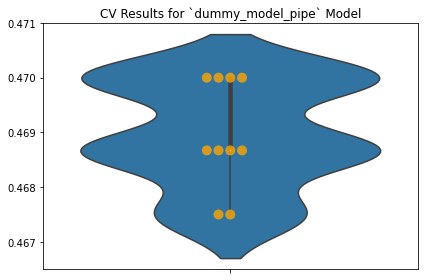

In [36]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


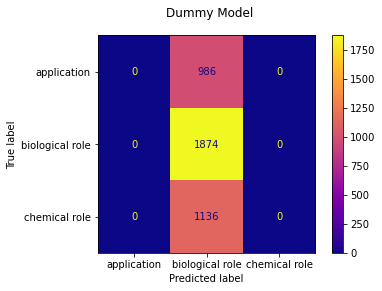

In [37]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_pipe, X_train, y_train, ax=ax, cmap="plasma");

### Logistic Regression

In [38]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X_train, y_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X_train, 
                       y=y_train)

CV Results for `log_pipe` model:
            0.63539 ± 0.01753 accuracy
        
 Train: 0.6371371371371372


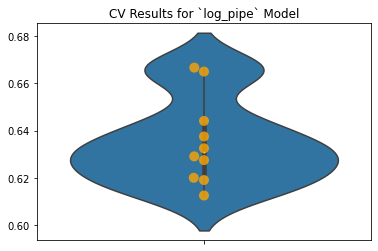

In [39]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


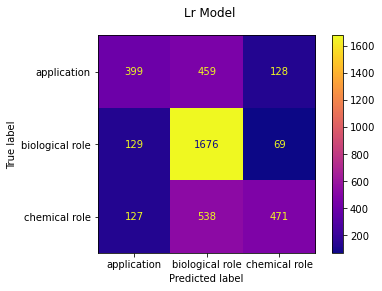

In [40]:
fig, ax = plt.subplots()

fig.suptitle("Lr Model")

plot_confusion_matrix(logreg_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

#plot_roc_curve(logreg_model_pipe, X_train, y_train);

### Decision Trees

In [41]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42, max_depth=13))])

dt_model_pipe.fit(X_train, y_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `dt_pipe` model:
            0.78779 ± 0.01815 accuracy
        
 Train: 0.9166666666666666


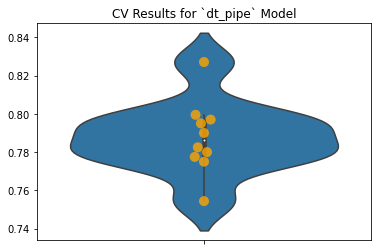

In [42]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


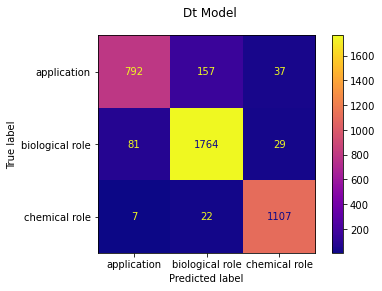

In [43]:
fig, ax = plt.subplots()

fig.suptitle("Dt Model")

plot_confusion_matrix(dt_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

#plot_roc_curve(dt_model_pipe, X_train, y_train);

### Random Forest

In [44]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42, max_depth=13))])

rfc_model_pipe.fit(X_train, y_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X_train, 
                          y=y_train)

CV Results for `forest_pipe` model:
            0.83684 ± 0.02430 accuracy
        
 Train: 0.9244244244244244


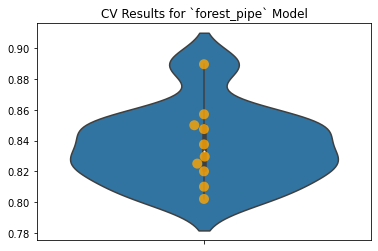

In [45]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


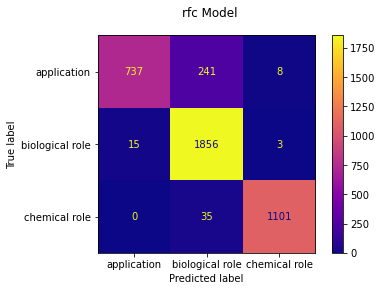

In [46]:
fig, ax = plt.subplots()

fig.suptitle("rfc Model")

plot_confusion_matrix(rfc_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

#plot_roc_curve(rfc_model_pipe, X_train, y_train);

### KNeighborsClassifier

In [47]:
knn_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('knn', KNeighborsClassifier())])

knn_model_pipe.fit(X_train, y_train)

knn_pipe = ModelWithCV(model=knn_model_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `knn_pipe` model:
            0.79405 ± 0.01275 accuracy
        
 Train: 0.8673673673673674


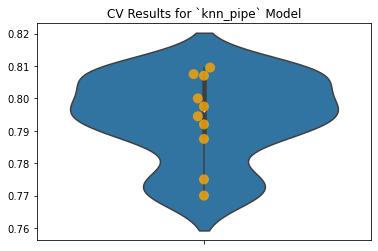

In [48]:
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax=ax);

knn_pipe.print_cv_summary()

train_score = knn_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


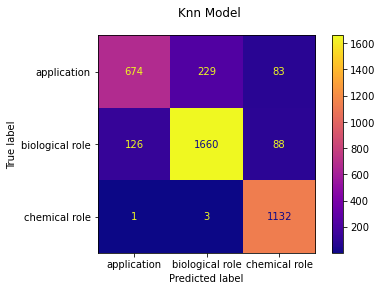

In [49]:
fig, ax = plt.subplots()

fig.suptitle("Knn Model")

plot_confusion_matrix(knn_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### GradientBoostingClassifier

In [50]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X_train, y_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `boost_pipe` model:
            0.77628 ± 0.01958 accuracy
        
 Train: 0.8103103103103103


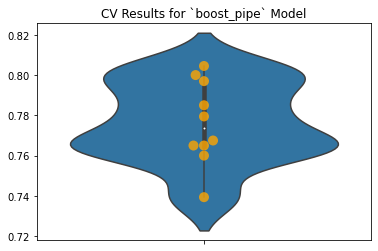

In [51]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


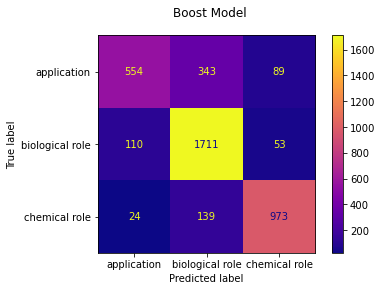

In [52]:
fig, ax = plt.subplots()

fig.suptitle("Boost Model")

plot_confusion_matrix(gbc_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### Neural Networks

#### Creating NN Helper Function

In [93]:
def model_metrics(results):
    
#    results = model.history
    
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']
    train_recall = results.history['recall']
    train_precision = results.history['precision']
    
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
    val_recall = results.history['val_recall']
    val_precision = results.history['val_precision']
    
    print(f"AUC score (train final epoch): {results.history['auc'][-1]:.3f}")
    print(f"AUC score (val final epoch)  : {results.history['val_auc'][-1]:.3f}")

    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()


    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    
    sns.lineplot(x=results.epoch, y=train_recall, ax=ax3, label='train_recall')
    sns.lineplot(x=results.epoch, y=val_recall, ax=ax3, label='val_recall')
    ax3.set_title('Recall')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Recall')
    ax3.legend()


    sns.lineplot(x=results.epoch, y=train_precision, ax=ax4, label='train_precision')
    sns.lineplot(x=results.epoch, y=val_precision, ax=ax4, label='val_precision')
    ax4.set_title('Precision')    
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend()

In [94]:
def conf_and_rocauc(model):
    
    #confusion matrix
    
    y_pred = model.predict(test_set)
    y_hat = (y_pred > 0.5)           
    display(ConfusionMatrixDisplay(
        confusion_matrix(test_set.classes, y_hat), 
        display_labels=['Normal', 'Pneumonia']).plot());
    
    
    #ROC_AUC
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set.classes, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure()
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

#### First Simple NN Model

In [328]:
ohe = OneHotEncoder(sparse=False)
y_train.reshape(-1,1)
y_pure_train = ohe.fit_transform(y_train)
#y_binary = to_categorical(new_y)
#input_shape = (1,X_train.shape[1],1)

AttributeError: 'Series' object has no attribute 'reshape'

In [321]:
y_train.values

array(['biological role', 'biological role', 'biological role', ...,
       'application', 'application', 'biological role'], dtype=object)

In [244]:
tf.convert_to_tensor(X_train.values)

<tf.Tensor: id=24954, shape=(3996, 103), dtype=float64, numpy=
array([[249.29, 123.  , 285.  , ...,   0.  ,   0.  ,   0.  ],
       [126.11,  66.  , 116.  , ...,   0.  ,   0.  ,   1.  ],
       [108.09,  46.1 ,  62.  , ...,   0.  ,  -2.  ,   2.  ],
       ...,
       [274.4 ,  26.3 , 290.  , ...,   0.  ,   0.  ,   4.  ],
       [208.22,  69.3 , 294.  , ...,   0.  ,   0.  ,   1.  ],
       [174.2 ,  92.4 , 180.  , ...,   0.  ,   0.  ,   0.  ]])>

In [272]:
normalizer = tf.keras.layers.LayerNormalization(axis=-1)
normalizer.build(X_train)

KeyError: 3995

In [331]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))

In [332]:
numeric_batches = numeric_dataset.shuffle(1000).batch(32)

In [256]:
fsm = models.Sequential([
    #layers.Reshape((1,X_train.shape[1],1)),
    #layers.Flatten(input_shape=(3996, 103, 1)),
    #layers.Dense(64,input_shape = (1,X_train.shape[1],1)),
    layers.Dense()
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(3, activation='softmax')
])

fsm.compile(
    optimizer='SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 
             'TruePositives', 'TrueNegatives',
             'FalsePositives', 'FalseNegatives', 
             'AUC']
)

fsm.summary()

SyntaxError: invalid syntax (4052013867.py, line 6)

In [292]:
# Now that the model is created, we can fit it to our training data

fsm_results = fsm.fit(numeric_batches,
                      epochs=20,
                      batch_size=None, 
                      verbose=1,
                      validation_split=.2)

SyntaxError: invalid syntax (3300179985.py, line 4)

In [ ]:
model_metrics(fsm_results)

In [ ]:
conf_and_rocauc(fsm)

In [ ]:
fsm.evaluate(test_set)

In [334]:
multilayer_model = models.Sequential([
    layers.Reshape((1,X_train.shape[1],1)),
    layers.Conv2D(filters = 32, kernel_size = (1,5),padding = 'Same',
             activation ='relu', input_shape = (1,X_train.shape[1],1)),

    layers.MaxPooling2D(pool_size = (1,6), strides=(1,2)),

    layers.Flatten(),
    layers.Dense (500, activation='relu'),
    layers.Dense (1, activation='sigmoid')])
    

multilayer_model.compile(optimizer='SGD',
                         loss='categorical_crossentropy',
                         metrics=['accuracy', 'Recall', 'Precision', 
                                  'TruePositives', 'TrueNegatives', 
                                  'FalsePositives', 'FalseNegatives', 
                                  'AUC'])

#multilayer_model.summary()

In [337]:
tf.keras.backend.set_floatx('float64')
multilayer_model_results = multilayer_model.fit(numeric_batches,
                                                epochs=200,
                                                batch_size=None, 
                                                verbose=1)
                                                #validation_split=.2)

Epoch 1/200
      1/Unknown - 0s 48ms/step

2022-05-26 14:26:47.554433: W tensorflow/core/framework/op_kernel.cc:1599] OP_REQUIRES failed at cast_op.cc:123 : Unimplemented: Cast string to float is not supported
2022-05-26 14:26:47.554463: E tensorflow/core/common_runtime/executor.cc:642] Executor failed to create kernel. Unimplemented: Cast string to float is not supported
	 [[{{node loss/output_1_loss/Cast}}]]


UnimplementedError:  Cast string to float is not supported
	 [[node loss/output_1_loss/Cast (defined at Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_57026]

Function call stack:
distributed_function


#### Multilayer Model

In [ ]:
multilayer_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

multilayer_model.compile(optimizer='SGD',
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'Recall', 'Precision', 
                                  'TruePositives', 'TrueNegatives', 
                                  'FalsePositives', 'FalseNegatives', 
                                  'AUC'])

multilayer_model.summary()

In [ ]:
multilayer_model_results = multilayer_model.fit(train_set_aug, 
                                                epochs=200,
                                                batch_size=None, 
                                                verbose=1, 
                                                validation_data=validation_set_aug)

In [ ]:
model_metrics(multilayer_model_results)

In [ ]:
conf_and_rocauc(multilayer_model)

#### Convolutional Neural Networks Model

In [ ]:
deep_cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

deep_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'Recall', 'Precision', 
                          'TruePositives', 'TrueNegatives', 
                          'FalsePositives', 'FalseNegatives', 
                          'AUC'])

deep_cnn.summary()

In [ ]:
deep_cnn_results = deep_cnn.fit(train_set_aug, 
                                epochs=200, 
                                batch_size=None, 
                                validation_data=validation_set_aug)

In [ ]:
model_metrics(deep_cnn_results)

In [ ]:
conf_and_rocauc(deep_cnn)

#### Update CNN with Dropout

In [ ]:
deep_cnn_updated = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

deep_cnn_updated.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])

In [ ]:
deep_cnn_updated_results = deep_cnn_updated.fit(train_set_aug, 
                                                epochs=200, 
                                                batch_size=None, 
                                                validation_data=validation_set_aug)

deep_cnn_updated.summary()

In [ ]:
model_metrics_from_dataframe(deep_cnn_updated_history)

In [ ]:
conf_and_rocauc(deep_cnn_updated)

In [ ]:
deep_cnn_updated.evaluate(test_set)

### Grid Search

In [53]:
params_rfc = {
    'rfc__n_estimators' : [100, 125, 150],
    'rfc__max_depth' : [7, 10, 13],
    #'rfc__max_leaf_nodes' : [599, 600, 601],
    #'rfc__criterion' : ['gini', 'entropy']}
}

gs_rfc = GridSearchCV(rfc_model_pipe, params_rfc, n_jobs=-1, cv=5, verbose=3)

gs_rfc.fit(X_train, y_train)

#n estimators 100 125 150
#max depth 5 7 10
#that's it
#use xgboost 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric_rt at 0x7f9c09b5cef0>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['MolecularWeight', 'TPSA', 'Complexity', 'HBondDonorCount',
       'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'H', 'He',
       'Li',
       ...
       'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'FCharge', 'XLogP_qcut'],
      dtype='object', length=103))])),
             

In [54]:
gs_rfc.best_params_

{'rfc__max_depth': 13, 'rfc__n_estimators': 150}

In [55]:
gs_rfc.best_score_

0.8335860450563203

In [56]:
final_rt_model_pipe = gs_rfc.best_estimator_

## Role Type Classification Evaluation

### Final Role Type Model

In [57]:
final_rt_model_pipe.fit(X_train, y_train)

final_rt_pipe = ModelWithCV(model=final_rt_model_pipe,
                         model_name='final_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `final_pipe` model:
            0.83685 ± 0.02150 accuracy
        
 Train: 0.924924924924925
 Test: 0.8402100525131283


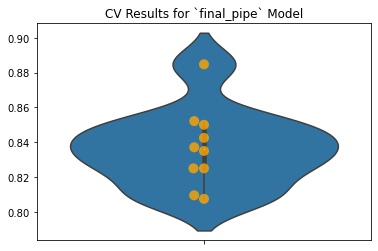

In [58]:
fig, ax = plt.subplots()

final_rt_pipe.plot_cv(ax=ax);

final_rt_pipe.print_cv_summary()

train_score = final_rt_model_pipe.score(X_train, y_train)
test_score = final_rt_model_pipe.score(X_test, y_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


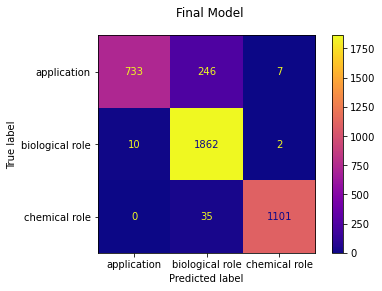

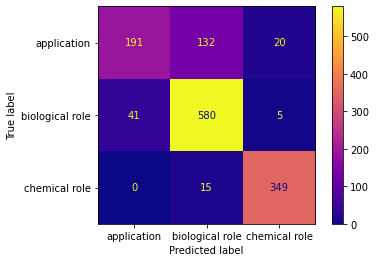

In [59]:
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(final_rt_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

plot_confusion_matrix(final_rt_model_pipe, X_test, y_test, cmap="plasma");

In [60]:
y_hat = final_rt_model_pipe.predict(X_test)
print(f'''Final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}''')

Final model's accuracy on the test set is 0.84


## Role Type Feature Importances

In [61]:
rfc_features = final_rt_model_pipe.named_steps['rfc'].feature_importances_

num_rt_features = grab_numeric_rt(X_train).columns

num_rt_list = list(num_rt_features)

features_rt_df = pd.DataFrame(rfc_features, num_rt_list, columns=['rfc_features'])

features_rt_df.sort_values(by='rfc_features', ascending=False).head(20)

,rfc_features
Complexity,0.113527
C,0.084105
H,0.083040
MolecularWeight,0.079651
TPSA,0.076706
RotatableBondCount,0.067186
HeavyAtomCount,0.064225
HBondDonorCount,0.062841
O,0.056307
HBondAcceptorCount,0.054856


In [62]:
final_rt_model_pipe.fit(X,y)

final_rt_pipe = ModelWithCV(model=final_rt_model_pipe,
                         model_name='final_pipe',
                         X=X,
                         y=y)

# Role Name Classification

## Role Name Data

In [499]:
clean_df.shape

(10136, 106)

In [500]:
clean_df.RoleName.value_counts()

metabolite                                            1573
plant metabolite                                      1453
human metabolite                                       730
mouse metabolite                                       580
epitope                                                500
                                                      ... 
ultraviolet filter                                       1
EC 3.1.26.13 (retroviral ribonuclease H) inhibitor       1
nicotinic antagonist                                     1
EC 1.3.1.72 (&#916;24-sterol reductase) inhibitor        1
adenosine A3 receptor agonist                            1
Name: RoleName, Length: 600, dtype: int64

In [501]:
balanced_rn_df = clean_df[clean_df.groupby('RoleName').RoleName.transform('count')>14]
balanced_rn_df.RoleName.value_counts()

metabolite                1573
plant metabolite          1453
human metabolite           730
mouse metabolite           580
epitope                    500
                          ... 
antidepressant              16
volatile oil component      16
antiviral agent             16
radioopaque medium          15
buffer                      15
Name: RoleName, Length: 61, dtype: int64

In [502]:
bio_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'biological role']
chem_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'chemical role']
app_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'application']

In [503]:
len(balanced_rn_df.RoleName.value_counts().index)

61

In [504]:
balanced_rn_df.shape

(8569, 106)

In [505]:
balanced_rn_df

,ChEBI,MolecularWeight,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,H,He,...,Fr,Ra,Ac,Th,Pa,U,FCharge,XLogP_qcut,RoleType,RoleName
0,19032,143.410000,0.0,10.0,0.0,0.0,1.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,biological role,mutagen
16,28741,41.988172,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,biological role,mutagen
21,28775,610.600000,234.0,940.0,8.0,15.0,7.0,43.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,biological role,mutagen
22,22899,330.290000,99.1,662.0,1.0,7.0,3.0,24.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,biological role,antimicrobial agent
25,25187,156.260000,20.2,120.0,1.0,1.0,1.0,11.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,biological role,volatile oil component
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10448,190185,796.800000,340.0,1390.0,11.0,19.0,11.0,55.0,52.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,hapten
10449,190305,1208.600000,362.0,1780.0,13.0,20.0,47.0,84.0,113.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,biological role,epitope
10450,190306,1354.700000,421.0,2080.0,15.0,24.0,49.0,94.0,123.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,biological role,epitope
10451,190307,1063.400000,275.0,1420.0,10.0,16.0,42.0,74.0,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,biological role,epitope


### Role Name Train-Test Split

In [506]:
X1 = balanced_rn_df.drop(['RoleName', 'ChEBI'], axis=1)
y1 = balanced_rn_df['RoleName']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)

In [507]:
X2 = bio_rn_df.drop(['RoleName', 'ChEBI'], axis=1)
y2 = bio_rn_df['RoleName']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

In [508]:
X3 = chem_rn_df.drop(['RoleName', 'ChEBI'], axis=1)
y3 = chem_rn_df['RoleName']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

In [509]:
X4 = app_rn_df.drop(['RoleName', 'ChEBI'], axis=1)
y4 = app_rn_df['RoleName']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=42)

## Role Name Modelling

In [418]:
def grab_numeric_rn(df):
    return df.select_dtypes(include=['float', 'int'])

def grab_object_rn(df):
    return df.select_dtypes(include=['object'])

GrabNumeric_rn = FunctionTransformer(grab_numeric_rn)
GrabObject_rn = FunctionTransformer(grab_object_rn)

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric_rn),
                              ('ss', StandardScaler())])

subpipe_cat = Pipeline(steps=[('get_cat', GrabObject_rn),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, X1_train.columns),
    ('subpipe_cat', subpipe_cat, X1_train.columns),])

### Baseline Model

In [398]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X1_train, y1_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X1_train,
    y=y1_train)

CV Results for `dummy_model_pipe` model:
            0.18143 ± 0.00072 accuracy
        
 Train: 0.18143459915611815


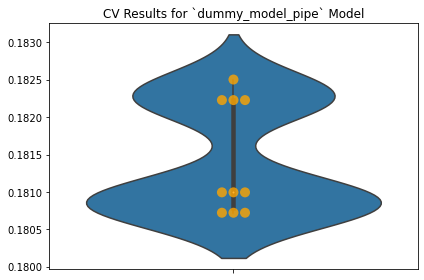

In [387]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Logistic Regression

In [74]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X1_train, y1_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X1_train, 
                       y=y1_train)

CV Results for `log_pipe` model:
            0.50756 ± 0.01884 accuracy
        
 Train: 0.5162892332141438


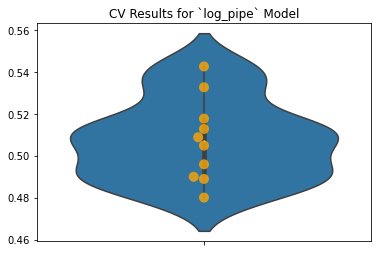

In [75]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Decision Trees

In [76]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42, max_depth=10))])

dt_model_pipe.fit(X1_train, y1_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X1_train,
                         y=y1_train)

CV Results for `dt_pipe` model:
            0.56973 ± 0.02419 accuracy
        
 Train: 0.6805721096543504


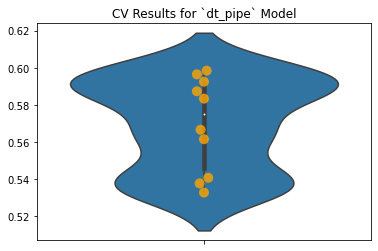

In [77]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Random Forest

In [479]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42, max_depth=11))])

rfc_model_pipe.fit(X1_train, y1_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X1_train, 
                          y=y1_train)

CV Results for `forest_pipe` model:
            0.50732 ± 0.01947 accuracy
        
 Train: 0.619514472455649


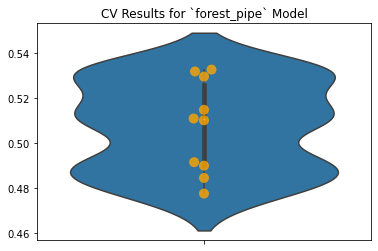

In [480]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

In [481]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42, max_depth=11))])

rfc_model_pipe.fit(X2_train, y2_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X2_train, 
                          y=y2_train)

CV Results for `forest_pipe` model:
            0.50940 ± 0.01558 accuracy
        
 Train: 0.6457793889176593


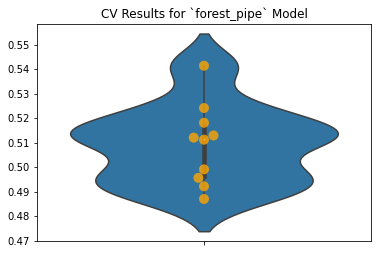

In [482]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

In [483]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42, max_depth=11))])

rfc_model_pipe.fit(X3_train, y3_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X3_train, 
                          y=y3_train)

CV Results for `forest_pipe` model:
            0.71667 ± 0.29861 accuracy
        
 Train: 1.0


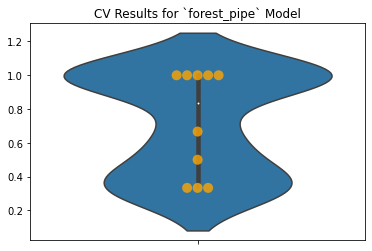

In [484]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

In [485]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42, max_depth=11))])

rfc_model_pipe.fit(X4_train, y4_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X4_train, 
                          y=y4_train)

CV Results for `forest_pipe` model:
            0.64522 ± 0.04710 accuracy
        
 Train: 0.9735973597359736


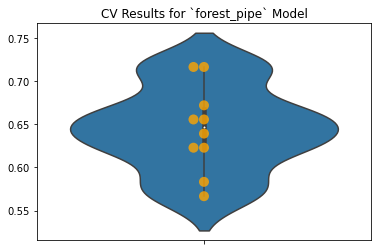

In [486]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X4_train, y4_train)
print(f' Train: {train_score}')

### GradientBoostingClassifier

In [510]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X1_train, y1_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X1_train,
                         y=y1_train)

CV Results for `boost_pipe` model:
            0.50419 ± 0.02770 accuracy
        
 Train: 0.7710862122626828


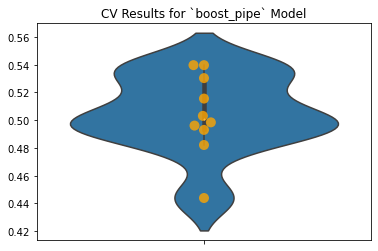

In [511]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

In [512]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X2_train, y2_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X2_train,
                         y=y2_train)

CV Results for `boost_pipe` model:
            0.51061 ± 0.01946 accuracy
        
 Train: 0.7610909718625928


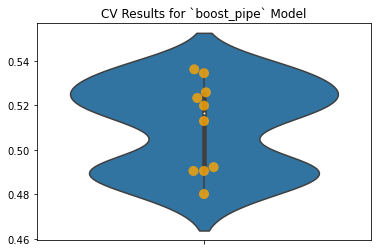

In [513]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

In [514]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X3_train, y3_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X3_train,
                         y=y3_train)

CV Results for `boost_pipe` model:
            0.78333 ± 0.27938 accuracy
        
 Train: 1.0


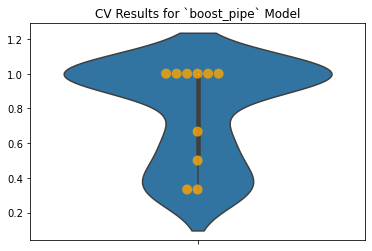

In [515]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

In [516]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X4_train, y4_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X4_train,
                         y=y4_train)

CV Results for `boost_pipe` model:
            0.66331 ± 0.05274 accuracy
        
 Train: 1.0


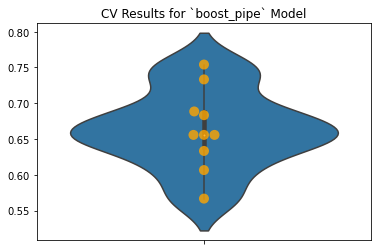

In [517]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X4_train, y4_train)
print(f' Train: {train_score}')

### Grid Search

In [82]:
params_rfc = {
    'rfc__n_estimators' : [100, 125, 150],
    'rfc__max_depth' : [7, 10, 13],
    #'rfc__max_leaf_nodes' : [599, 600, 601],
    #'rfc__criterion' : ['gini', 'entropy']}
}

gs_rfc = GridSearchCV(rfc_model_pipe, params_rfc, n_jobs=-1, cv=5, verbose=3)

gs_rfc.fit(X1_train, y1_train)

#n estimators 100 125 150
#max depth 5 7 10
#that's it
#use xgboost 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric_rn at 0x7f9c0a0bc7a0>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['MolecularWeight', 'TPSA', 'Complexity', 'HBondDonorCount',
       'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'H', 'He',...
                                                                         Index(['MolecularWeight', 'TPSA', 'Complexity', 'HBondDonorCount',
       'HBond

In [83]:
gs_rfc.best_params_

{'rfc__max_depth': 13, 'rfc__n_estimators': 100}

In [84]:
gs_rfc.best_score_

0.6225662904400805

In [85]:
final_rn_model_pipe = gs_rfc.best_estimator_

## Role Name Classification Evaluation

### Final Role Name Model

In [86]:
final_rn_model_pipe.fit(X1_train, y1_train)

final_rn_pipe = ModelWithCV(model=final_rn_model_pipe,
                         model_name='final_pipe',
                         X=X1_train,
                         y=y1_train)

CV Results for `final_pipe` model:
            0.62396 ± 0.02125 accuracy
        
 Train: 0.7844656336909018
 Test: 0.6174016686531585


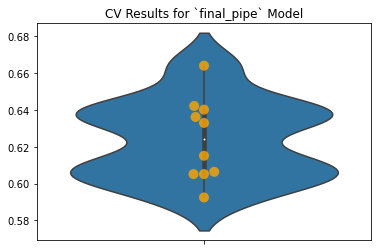

In [87]:
fig, ax = plt.subplots()

final_rn_pipe.plot_cv(ax=ax);

final_rn_pipe.print_cv_summary()

train_score = final_rn_model_pipe.score(X1_train, y1_train)
test_score = final_rn_model_pipe.score(X1_test, y1_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

In [88]:
y1_hat = final_rn_model_pipe.predict(X1_test)
print(f'''Final model's accuracy on the test set is {round(accuracy_score(y1_test, y1_hat), 2)}''')

Final model's accuracy on the test set is 0.62


## Role Name Feature Importances

In [89]:
rfc_features = final_rn_model_pipe.named_steps['rfc'].feature_importances_

num_rn_features = grab_numeric_rn(X1_train).columns
num_rn_list = list(num_rn_features)

ohe_rn_features = final_rn_model_pipe.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names()
ohe_rn_list = list(ohe_rn_features)

# creating a combined list of all these features from both numerical and categorical columns. 

features_list = num_rn_list + ohe_rn_list

features_rn_df = pd.DataFrame(rfc_features, features_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rfc_features
RotatableBondCount,0.089901
Complexity,0.079416
H,0.079125
MolecularWeight,0.071840
TPSA,0.071317
C,0.068144
N,0.065651
HeavyAtomCount,0.062645
HBondDonorCount,0.062348
O,0.059657


In [90]:
features_rt_df.sort_values(by='rfc_features', ascending=False).head(20)

,rfc_features
Complexity,0.113527
C,0.084105
H,0.083040
MolecularWeight,0.079651
TPSA,0.076706
RotatableBondCount,0.067186
HeavyAtomCount,0.064225
HBondDonorCount,0.062841
O,0.056307
HBondAcceptorCount,0.054856


In [91]:
final_rn_model_pipe.fit(X1,y1)

final_rn_pipe = ModelWithCV(model=final_rn_model_pipe,
                         model_name='final_pipe',
                         X=X1,
                         y=y1)

In [92]:
#var_array = chem phys inputs

#type_pred = final_rt_model_pipe.predict(var_array)

#var_array.append(type_pred)

#name_pred = final_rn_model_pipe.predict(var_array)

[CV 4/5] END rfc__max_depth=7, rfc__n_estimators=125;, score=0.705 total time=   0.3s
[CV 4/5] END rfc__max_depth=10, rfc__n_estimators=100;, score=0.788 total time=   0.3s
[CV 4/5] END rfc__max_depth=10, rfc__n_estimators=150;, score=0.790 total time=   0.4s
[CV 4/5] END rfc__max_depth=13, rfc__n_estimators=125;, score=0.842 total time=   0.4s
[CV 2/5] END rfc__max_depth=7, rfc__n_estimators=125;, score=0.533 total time=   0.3s
[CV 1/5] END rfc__max_depth=10, rfc__n_estimators=100;, score=0.568 total time=   0.4s
[CV 1/5] END rfc__max_depth=10, rfc__n_estimators=150;, score=0.574 total time=   0.5s
[CV 1/5] END rfc__max_depth=13, rfc__n_estimators=125;, score=0.596 total time=   0.5s
[CV 2/5] END rfc__max_depth=7, rfc__n_estimators=125;, score=0.726 total time=   0.3s
[CV 3/5] END rfc__max_depth=10, rfc__n_estimators=100;, score=0.770 total time=   0.3s
[CV 3/5] END rfc__max_depth=10, rfc__n_estimators=150;, score=0.767 total time=   0.4s
[CV 3/5] END rfc__max_depth=13, rfc__n_estimat